In [1]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE,r2_score
from sklearn.linear_model import Lasso,LassoCV
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def compare_plot(model_name,model_pre,y_test):
    plt.plot(list(range(0, len(x_test))), y_test, marker='o')
    plt.plot(list(range(0, len(x_test))), model_pre, marker='+')
    plt.legend(['真实值', '预测值'])
    plt.title(f'{model_name}对房屋损坏率预测值与真实值对比')
    plt.show()

In [3]:
data=pd.read_csv(r"../data/alllog_data_std.csv")
data.head()

,Wind speed,Distance to typhoon,rainfall,distance_first_impact,Experience,Elevation,Slope,slope_stdev,Population density,Poverty incidence,% skilled Agriculture/Forestry/Fishermen,% strong roof type,% strong wall type,rel
0,-1.620324,1.331609,-4.468727,2.905019,1.237057,-1.277479,-1.063496,-0.394895,1.252364,-0.927216,-0.584678,0.790468,0.953142,0.000223
1,-0.634006,0.555758,-1.413392,1.167174,-1.440887,-0.367466,-0.586297,-0.578657,0.288251,-0.636713,-0.923616,0.479060,0.066161,0.001896
2,-1.078500,0.971052,0.431275,1.220913,-1.440887,-0.192045,-0.364515,-0.550292,-0.065459,1.313923,1.015609,-0.227804,-0.739041,0.010073
3,-0.634006,0.662958,-1.625482,1.104420,-1.440887,0.459659,0.119831,0.043607,-0.015649,0.387523,0.343028,0.785736,0.349793,0.000557
4,-1.078500,0.832699,-0.790571,1.055721,-1.440887,0.909320,0.550522,0.434510,0.019202,0.322066,0.600348,0.455507,0.266969,0.000671


In [4]:
data=shuffle(data)
X_data=data.iloc[:,:-1]
Y_data=data.iloc[:,-1]

## Lasso

In [5]:
lasso=Lasso(alpha=0.001,normalize=False)
lasso.fit(X_data,Y_data)
print("相关系数为:",np.round(lasso.coef_,4))
print("相关系数非零个数为:",np.sum(lasso.coef_!=0))
model = SelectFromModel(lasso, prefit=True)
X_data_new= model.transform(X_data)

相关系数为: [ 0.1269  0.0221  0.     -0.0284 -0.0094 -0.0617  0.0067  0.0326 -0.0136
  0.0067 -0.0056 -0.0143 -0.0116]
相关系数非零个数为: 12


D:\anaconda\lib\site-packages\sklearn\linear_model\_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
D:\anaconda\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [6]:
X_data=X_data_new.copy()

In [7]:
x_train,x_test,y_train,y_test=train_test_split(X_data,Y_data,test_size=0.2,random_state=2)
x_train.shape

(1292, 12)

In [10]:

rfr_params = {
    "n_estimators": [150,200,300],
    "max_depth": list(range(10,13)),
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [2, 3, 5],
    "max_features": ["sqrt", "log2", "auto"]
}
rfr = RandomForestRegressor(n_jobs=3)
rfr_grid_search = GridSearchCV(rfr, rfr_params, cv=5, scoring="neg_mean_squared_error")
rfr_grid_search.fit(x_train, y_train)
 
best_params = rfr_grid_search.best_params_
best_scores = rfr_grid_search.best_score_
print(best_params)

{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


0.01034647061509181 0.10171760228737114 0.7337074382197042


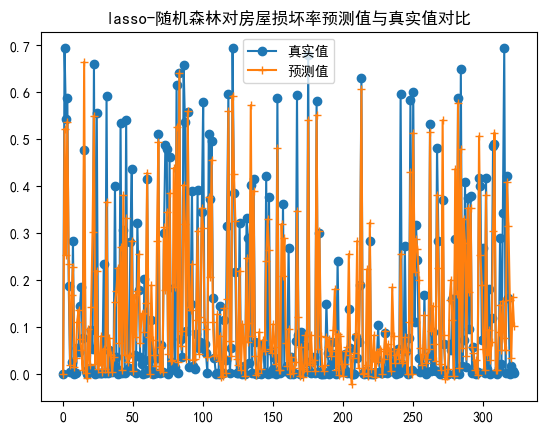

In [13]:
best_rfr=RandomForestRegressor(**best_params)
best_rfr.fit(x_train,y_train)
rfr_pred=best_rfr.predict(x_test)
rfr_mse=MSE(y_true=y_test,y_pred=rfr_pred)
rmse=np.sqrt(rfr_mse)
r2=r2_score(y_test,rfr_pred)
print(rfr_mse,rmse,r2)
compare_plot('lasso-随机森林',y_pred,y_test)

In [340]:
import xgboost as xgb
xgb_m=xgb.XGBRegressor(max_depth=5,learning_rate=0.1,n_estimators=100)
xgb_m.fit(x_train,y_train)
y_pred=xgb_m.predict(x_test)
mse=MSE(y_test,y_pred)
rmse=np.sqrt(mse)
print(mse,rmse,r2_score(y_test,y_pred))


0.009664590989527986 0.09830865165145937 0.7303468251210795


In [24]:
from sklearn.svm import SVR
svr=SVR()
params={
    'kernel':['rbf'],
    'gamma':np.logspace(-5,0,num=6,base=2.0),
    'C':np.logspace(-5, 5, num=11, base=2.0)
}
grid_search=GridSearchCV(svr,params,cv=5,n_jobs=4,scoring="neg_mean_squared_error")
grid_search.fit(x_train,y_train)
print(grid_search.best_params_)


{'C': 0.5, 'gamma': 0.0625, 'kernel': 'rbf'}


0.010163968704428678 0.1008165100786011 0.7383726595198639


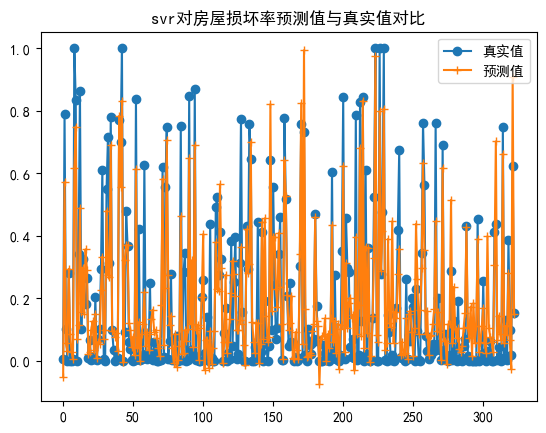

In [50]:
from sklearn.svm import SVR
svr=SVR(**grid_search.best_params_)
#svr=SVR()
svr.fit(x_train,y_train)
y_pred=svr.predict(x_test)
mse=MSE(y_test,y_pred)
rmse=np.sqrt(mse)
print(mse,rmse,r2_score(y_test,y_pred))
compare_plot('svr',np.expm1(y_pred),np.expm1(y_test))